In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/My Drive/Zindi/Competitions/ZINDI_CGIAR/data.zip" images.zip # You may have them stored in a folder, in which case modify the path.

In [3]:
# Now we can unzip:
!unzip -q images.zip

In [6]:
# import Libraries
import random
import os
import gc
import random
random.seed(3)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *


In [8]:
!cp "/content/drive/My Drive/Zindi/Competitions/ZINDI_CGIAR/Train.csv" . 
!cp "/content/drive/My Drive/Zindi/Competitions/ZINDI_CGIAR/SampleSubmission.csv" .

In [9]:
# Read in the train csv
train = pd.read_csv('Train.csv')
train.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1


In [10]:
# Use only high quality images 
train_hq = train[train['label_quality']== 2]
train_hq.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
7,sYLqmiXV,3,2


In [11]:
# View the high quality dataframe to see if all growth stages are present within the high quality training csv
train_hq.growth_stage.unique()

array([4, 3, 7, 2, 5])

In [12]:
# How many images are of high quality
print("The number of images with hgh quality are:", train[train['label_quality']== 2].shape[0])

The number of images with hgh quality are: 2856


# Data Augmentation

In [13]:
import random
import numpy as np
import gc
SEED_VAL  = 304
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_all(SEED_VAL)

In [14]:
# image transformation
 
# Image Augmentation used for Densenet201 and  lr_max = slice (10e-7, 10e-6) with 40 epochs
tfms = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                        CropPad(size=256),
                        Zoom(max_zoom=1.5, p=0.5),
                        Warp(magnitude=0.5, p=0.5)
                       ])


# # Image Augmentation used for Resnet50 and lr_max = slice (3e-6) with 40 epochs
#tfms = setup_aug_tfms([Rotate(max_deg=15, p=1.),
#            RandomResizedCrop(p=1., size=256),
#            Brightness(max_lighting=1.0, p=0.4),
#            CropPad(size=256),
#            Zoom(max_zoom=1.0, p=0.2),
#            Warp(magnitude=0.2, p=0.2)
#            ] ) 


# # Image Augmentation used for Vgg16_bn and lr_max = slice (10e-6) with 40 epochs
# tfms = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
#                        CropPad(size=256),
#                        Zoom(max_zoom=1.1, p=0.5),
#                        Warp(magnitude=0.2, p=0.5)
#                       ])



#Creating Data Loader



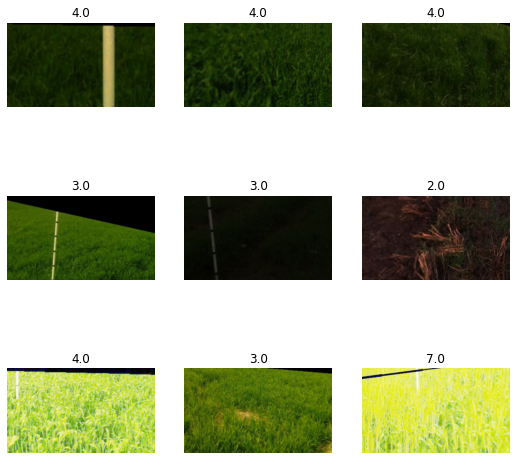

In [16]:
# Create our dataloaders
dls = ImageDataLoaders.from_df(train_hq, # train_hq if you only want the smaller high-quality set of images
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize((200,350)), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms,bs=40) #The only other change!
dls.show_batch()

# Define and Train Model

In [17]:
# Training the model
learn = cnn_learner(dls, densenet201, metrics=rmse, pretrained=True).to_fp16()
learn.fine_tune(70) 

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,_rmse,time
0,16.531965,11.097607,3.331307,00:21


epoch,train_loss,valid_loss,_rmse,time
0,9.935265,7.653308,2.766461,00:27
1,8.551916,5.832051,2.414964,00:27
2,7.114387,4.059359,2.014785,00:27
3,5.902111,3.176712,1.782333,00:27
4,4.858740,1.799828,1.341577,00:27
5,3.956605,0.965513,0.982605,00:28
6,3.383623,1.283590,1.132956,00:28
7,2.976077,0.785177,0.886102,00:27
8,2.668510,0.632597,0.795360,00:27
9,2.456887,0.566248,0.752494,00:28


# Make Predictions for the Sample Submission

In [18]:
 # Making test dataloader and Test Time Augementation
ss = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [19]:
# Making Submission
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier

In [20]:
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.749268
1,6P4wLVzI,3.773438
2,Tn6HIrdS,3.028442
3,EYM5R1TK,4.036499
4,fkcevlA0,5.035889


In [21]:
ss.to_csv('ZION_notebook_densenet201_BS40_size200_350_max_ligh_0.9_max_zoom_1.5_magnitude_0.5.csv',index=False)